In [1]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import cross


class SMACrossOver(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(SMACrossOver, self).__init__(feed)
        self.__instrument = instrument
        self.__position = None
        # We'll use adjusted close values instead of regular close values.
        self.setUseAdjustedValues(True)
        self.__prices = feed[instrument].getPriceDataSeries()
        self.__sma = ma.SMA(self.__prices, smaPeriod)

    def getSMA(self):
        return self.__sma

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if cross.cross_above(self.__prices, self.__sma) > 0:
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                # Enter a buy market order. The order is good till canceled.
                self.__position = self.enterLong(self.__instrument, shares, True)
        # Check if we have to exit the position.
        elif not self.__position.exitActive() and cross.cross_below(self.__prices, self.__sma) > 0:
            self.__position.exitMarket()

2021-07-29 20:14:18,449 quandl [INFO] Downloading AAPL 2011 to .\WIKI-AAPL-2011-quandl.csv
2021-07-29 20:14:19,430 quandl [INFO] Downloading AAPL 2012 to .\WIKI-AAPL-2012-quandl.csv


Sharpe ratio: 1.12


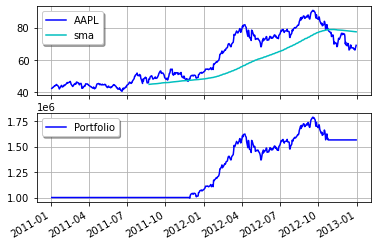

In [3]:
from __future__ import print_function

from pyalgotrade import plotter
from pyalgotrade.tools import quandl
from pyalgotrade.stratanalyzer import sharpe


def main(plot):
    instrument = "AAPL"
    smaPeriod = 163

    # Download the bars.
    feed = quandl.build_feed("WIKI", [instrument], 2011, 2012, ".")

    strat = SMACrossOver(feed, instrument, smaPeriod)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)

    if plot:
        plt = plotter.StrategyPlotter(strat, True, False, True)
        plt.getInstrumentSubplot(instrument).addDataSeries("sma", strat.getSMA())

    strat.run()
    print("Sharpe ratio: %.2f" % sharpeRatioAnalyzer.getSharpeRatio(0.05))

    if plot:
        plt.plot()


if __name__ == "__main__":
    main(True)